# Confirmed cases and country trajectory charts for Poland
> Day by day statistics of new confirmed cases and comparison with other countries.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

In [1]:
#hide
import pandas as pd
import altair as alt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline
sns.set()

In [2]:
#hide
url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
       'csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = pd.read_csv(url)
# rename countries
df['Country/Region'] = df['Country/Region'].replace({'Korea, South': 'South Korea'})
df = df[~df['Country/Region'].isin(['Cruise Ship'])]   # Remove Ships
dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]

In [3]:
#hide
def plot_confirmed_cases_barplot(country, cutoff=30, logarithmic_scale=False):
  data_f = df[df['Country/Region'] == country]
  nb_cases = data_f.values[0][cutoff:].astype(float)
  dates = data_f.columns[cutoff:]
  df_ = pd.DataFrame({'Dates': dates,
                     'Confirmed_cases': nb_cases})
  
  
  plt.figure(figsize=(16, 6))

  g = sns.barplot(x="Dates", y="Confirmed_cases", data=df_)
  if logarithmic_scale:
    g.set(yscale="log")
    g.set_title('Confirmed cases in ' + country + ' (Logarithmic scale)')
  else:
    g.set_title('Confirmed cases in ' + country)
  var = g.set_xticklabels(g.get_xticklabels(), rotation=90)


## Number of total cases in Poland

Number of cases grows exponentially.

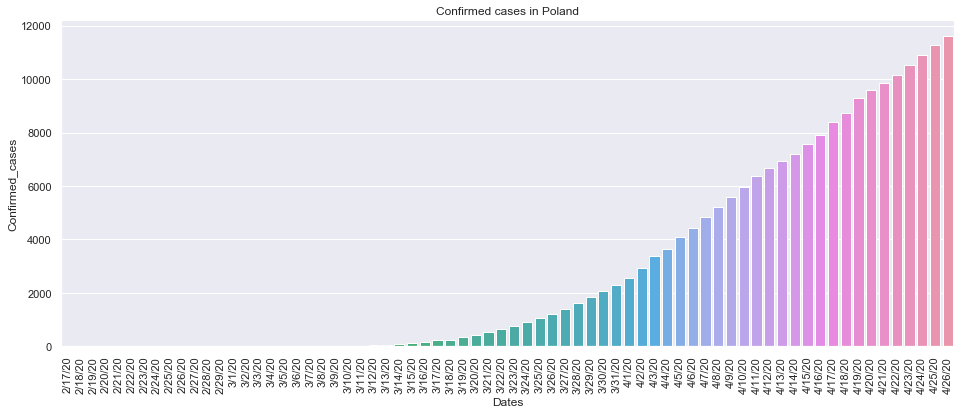

In [4]:
#hide_input
plot_confirmed_cases_barplot('Poland', cutoff=30)

Logarithmic scale shows how fast the number of new cases each day is increasing.

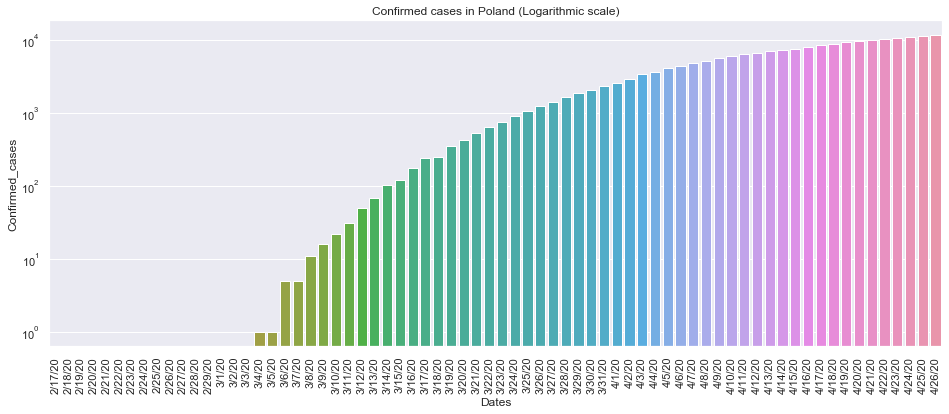

In [5]:
#hide_input
plot_confirmed_cases_barplot('Poland', cutoff=30, logarithmic_scale=True)

## New daily cases

In [6]:
#hide
def plot_new_cases_barplot(country, cutoff=30):
    data_f = df[df['Country/Region'] == country]
    nb_cases = data_f.values[0][cutoff:].astype(float)
    dates = data_f.columns[cutoff:]
    df_ = pd.DataFrame({'Dates': dates,
                     'Confirmed_cases': nb_cases})
    df_['MA'] = df_.iloc[:,1].rolling(window=7).mean()

    y_pos = np.arange(len(dates))
    plt.figure(figsize=(12, 4))
    df_['Confirmed_cases'].diff()
    plt.bar(range(len(df_['Confirmed_cases'].diff())), df_['Confirmed_cases'].diff())
    plt.plot(range(len(df_['MA'].diff())), df_['MA'].diff(), '--')
    plt.xticks(y_pos,dates, rotation=90)
    plt.title('New daily cases in '+country)

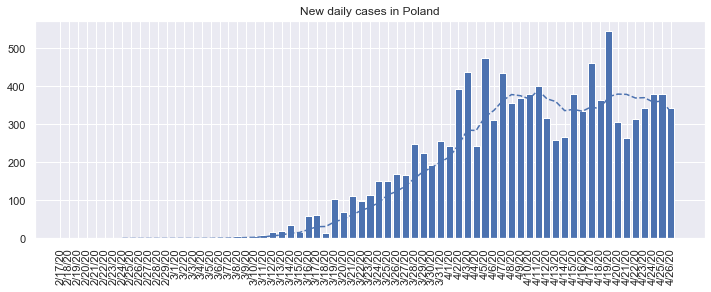

In [7]:
#hide_input
plot_new_cases_barplot('Poland')

## Country trajectories for total cases

Compare how the growth rate is different from other countries and their trajectories. By days since 100th confirmed case.

> Tip: Click (Shift+ for multiple) on countries in the legend to filter the visualization. 

In [8]:
#hide
dff = (df.groupby('Country/Region')[dt_cols].sum()
       .stack().reset_index(name='Confirmed Cases')
       .rename(columns={'level_1': 'Date', 'Country/Region': 'Country'}))
dff['Date'] = pd.to_datetime(dff['Date'], format='%m/%d/%y')

In [9]:
#hide
# dff['Country'].unique()

In [10]:
#hide
MIN_CASES = 50
LAST_DATE = dt_cols[-1]
# sometimes last column may be empty, then go backwards
for c in dt_cols[::-1]:
    if not df[c].fillna(0).eq(0).all():
        LAST_DATE = c
        break
countries = dff[dff['Date'].eq(LAST_DATE) & dff['Confirmed Cases'].ge(MIN_CASES) & 
        dff['Country'].ne('China')
       ].sort_values(by='Confirmed Cases', ascending=False)
countries = ['Lithuania', 'Poland', 'Greece', 'Ukraine', 'Italy', 'United Kingdom', 'Germany', 'Czechia', 'US', 'Estonia', 'France', 'Japan', 'South Korea', 'Latvia', 'Spain']

In [11]:
#hide
SINCE_CASES_NUM = 50
dff2 = dff[dff['Country'].isin(countries)].copy()
days_since = (dff2.assign(F=dff2['Confirmed Cases'].ge(SINCE_CASES_NUM))
              .set_index('Date')
              .groupby('Country')['F'].transform('idxmax'))
dff2['Days since 100 cases'] = (dff2['Date'] - days_since.values).dt.days.values
dff2 = dff2[dff2['Days since 100 cases'].ge(0)]

In [12]:
#hide
def get_country_colors(x):
    mapping = {
        'Italy': 'black',
        'Lithuania': '#E45756',
        'South Korea':  '#A1BA59',
        'Spain': '#F58518',
        'Germany': '#9D755D',
        'France': '#F58518',
        'US': '#2495D3',
        'Poland': '#2495D3',
        'United Kingdom': '#F58518',
        'Latvia': '#F58518',
        'Ukraine': 'brown',
        'Estonia': '#9467bd',
        'Japan': '#C1B7AD',
        'US':'#E45756',
        'Greece': 'pink',
        'Czechia': 'yellow'}
    return mapping.get(x, '#C1B7AD')

In [13]:
#hide_input
baseline_countries = ['Italy', 'South Korea', 'Japan']
max_date = dff2['Date'].max()
color_domain = list(dff2['Country'].unique())
color_range = list(map(get_country_colors, color_domain))

def make_since_chart(highlight_countries=[], baseline_countries=baseline_countries):
    selection = alt.selection_multi(fields=['Country'], bind='legend', 
                                    init=[{'Country': x} for x in highlight_countries + baseline_countries])

    base = alt.Chart(dff2, width=550).encode(
        x='Days since 100 cases:Q',
        y=alt.Y('Confirmed Cases:Q', scale=alt.Scale(type='log')),
        color=alt.Color(
            'Country:N',
            scale=alt.Scale(domain=color_domain, range=color_range),
            legend=alt.Legend(columns=2)),
        tooltip=list(dff2),
        opacity=alt.condition(selection, alt.value(1), alt.value(0.05))
    )
    max_day = dff2['Days since 100 cases'].max()
    ref = pd.DataFrame([[x, 100*1.33**x] for x in range(max_day+1)], columns=['Days since 100 cases', 'Confirmed Cases'])
    base_ref = alt.Chart(ref).encode(x='Days since 100 cases:Q', y='Confirmed Cases:Q')
    return (
        base_ref.mark_line(color='black', opacity=.5, strokeDash=[3,3]) +
        base_ref.transform_filter(
            alt.datum['Days since 100 cases'] >= max_day
        ).mark_text(dy=-6, align='right', fontSize=10, text='33% Daily Growth') +
        base.mark_line(point=True).add_selection(selection) + 
        base.transform_filter(
            alt.datum['Date'] >= int(max_date.timestamp() * 1000)
        ).mark_text(dy=-8, align='right', fontWeight='bold').encode(text='Country:N')
    ).properties(
        title=f"Compare {', '.join(highlight_countries)} trajectory with {', '.join(baseline_countries)}"
    )

In [14]:
#hide_input
chart3 = make_since_chart(['Poland'])
chart3


alt.LayerChart(...)

In [15]:
#hide_input
chart2 = make_since_chart(['Poland', 'Germany', 'Czechia'])
chart2

alt.LayerChart(...)

In [16]:

#hide_input
chart2 = make_since_chart(['Ukraine', 'Poland'])
chart2

alt.LayerChart(...)

In [17]:
#hide_input
chart2 = make_since_chart(['Poland', 'Spain', 'US'])
chart2

alt.LayerChart(...)

In [18]:

#hide_input
chart2 = make_since_chart(['France', 'Greece', 'Poland'])
chart2

alt.LayerChart(...)

## New daily cases in other countries

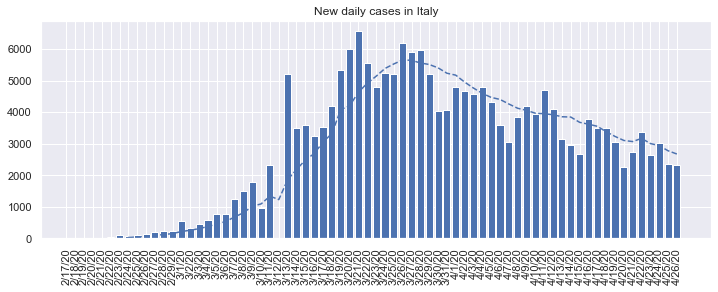

In [19]:
#hide_input
plot_new_cases_barplot('Italy')

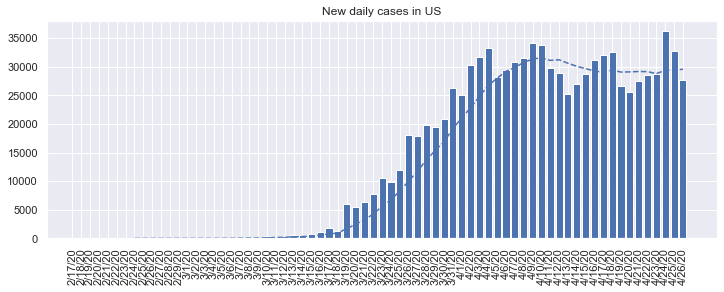

In [20]:
#hide_input
plot_new_cases_barplot('US')

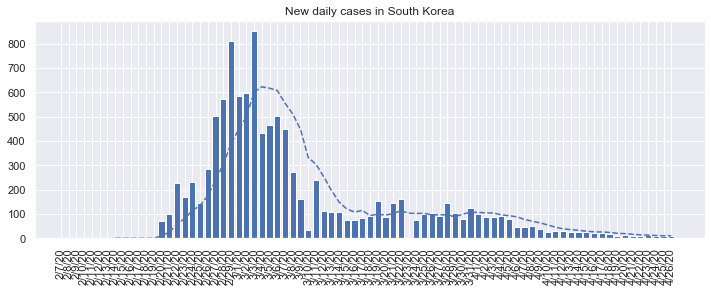

In [21]:
#hide_input
plot_new_cases_barplot('South Korea', cutoff=20)

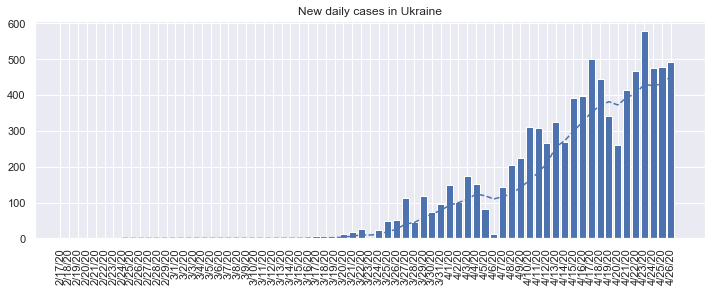

In [22]:
#hide_input
plot_new_cases_barplot('Ukraine')

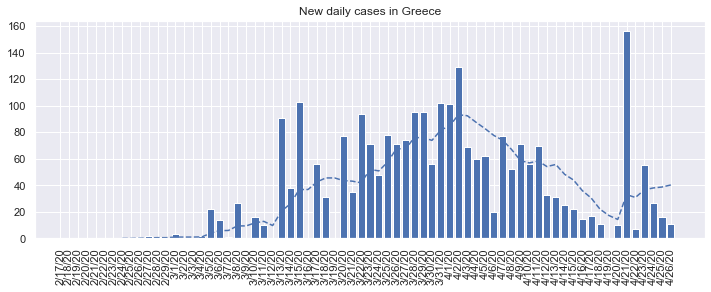

In [23]:
#hide_input
plot_new_cases_barplot('Greece')

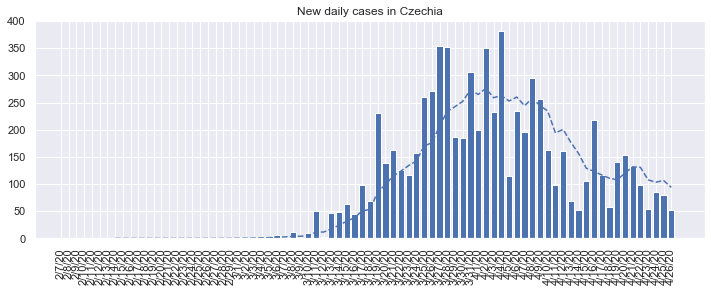

In [24]:
#hide_input
plot_new_cases_barplot('Czechia', cutoff=20)

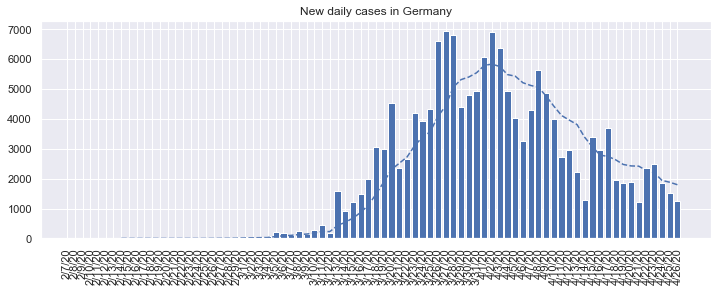

In [25]:
#hide_input
plot_new_cases_barplot('Germany', cutoff=20)